# CPU or GPU 

In [ ]:
# !pip uninstall mne
# pip install entropy
# !pip install --upgrade entropy

In [1]:
import tensorflow as tf
# Configuración de TensorFlow para usar la GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# # Configuración de TensorFlow para usar la CPU
# tf.config.set_visible_devices([], 'GPU')

# LIBRARIES 

In [2]:
# !pip list

In [3]:
# Library EEG
import mne

# Library System 
import os
import numpy as np
from tqdm import tqdm
import time

# Library Statistics
import scipy.stats
import random
from scipy.stats import entropy
from scipy.fft import fft
from scipy.signal import welch
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA


# Library GAN
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# Library Graph
import matplotlib.pyplot as plt
import seaborn as sns

# No Warning
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

In [4]:
os.getcwd()

'C:\\Users\\macka\\TFM_WD\\ORI\\SEEDs_FIF_RECOG_GAN'

# DATA

### Mapa 2D Canales.

In [5]:
electrode_positions= {
    "AF3": (6, 17),    "FP1":(8, 17),    "FPZ": (10, 17),    "FP2": (12, 17),    "AF4": (14, 17),
    "F7": (2, 15),    "F5": (4, 15),    "F3": (6, 15),    "F1": (8, 15),    "FZ": (10, 15),    "F2": (12, 15),    "F4": (14, 15),    "F6": (16, 15),    "F8": (18, 15), 
    "FT7": (2, 13),    "FC5": (4, 13),    "FC3": (6, 13),    "FC1": (8, 13),    "FCZ": (10, 13),    
    "FC2": (12, 13),    "FC4": (14, 13),    "FC6": (16, 13),    "FT8": (18, 13),   
    "T7": (2, 11),    "C5": (4, 11),    "C3": (6, 11),    "C1": (8, 11),    "CZ": (10, 11),    "C2": (12, 11),    "C4": (14, 11),    "C6": (16, 11),    "T8": (18, 11),  
    "TP7": (2, 9),    "CP5": (4, 9),    "CP3":(6, 9),    "CP1": (8, 9),    "CPZ": (10, 9),    "CP2": (12, 9),    "CP4": (14, 9),    "CP6": (16, 9),    "TP8": (18, 9),   
    "P7": (2, 7),    "P5":(4, 7),    "P3":(6, 7),    "P1":(8, 7),    "PZ":(10, 7),    "P2": (12, 7),    "P4": (14, 7),    "P6": (16, 7),    "P8": (18, 7),  
    "PO7": (4, 5),    "PO5":(6, 5),    "PO3": (8, 5),    "POZ":(10, 5),    "PO4": (12, 5),    "PO6": (14, 5),    "PO8": (16, 5),   
    "CB1": (6, 3),    "O1":(8, 3),    "OZ":(10, 3),    "O2":(12, 3),   
    "CB2": (14, 3),}

In [6]:
electrode_positions_matrix= {
    "AF3": (2,5),    "FP1":(2,7),    "FPZ": (2,9),    "FP2": (2,11),    "AF4": (2,13),
    "F7": (4, 1),    "F5": (4, 3),    "F3": (4, 5),    "F1": (4, 7),    "FZ": (4, 9),    "F2": (4, 11),    "F4": (4, 13),    "F6": (4, 15),    "F8": (4, 17), 
    "FT7": (6, 1),    "FC5": (6, 3),    "FC3": (6, 5),    "FC1":(6, 7),    "FCZ": (6, 9),    
    "FC2": (6, 11),    "FC4": (6, 13),    "FC6": (6, 15),    "FT8": (6,17),   
    "T7": (8, 1),    "C5": (8, 3),    "C3": (8, 5),    "C1": (8, 7),    "CZ": (8, 9),"C2": (8, 11),    "C4": (8, 13),    "C6": (8, 15),    "T8": (8, 17), 
    "TP7": (10, 1), "CP5": (10, 3), "CP3": (10, 5), "CP1": (10, 7), "CPZ": (10, 9), "CP2": (10, 11), "CP4": (10, 13), "CP6": (10, 15), "TP8": (10, 17),
    "P7": (12, 1), "P5": (12, 3), "P3": (12, 5), "P1": (12, 7), "PZ": (12, 9), "P2": (12, 11), "P4": (12, 13), "P6": (12, 15), "P8": (12, 17),
    "PO7": (14, 3), "PO5": (14, 5), "PO3": (14, 7), "POZ": (14, 9), "PO4": (14, 11), "PO6": (14, 13), "PO8": (14, 15),   
    "CB1": (16, 5),    "O1":(16, 7),    "OZ":(16, 9),    "O2":(16, 11),   
    "CB2": (16, 13),}

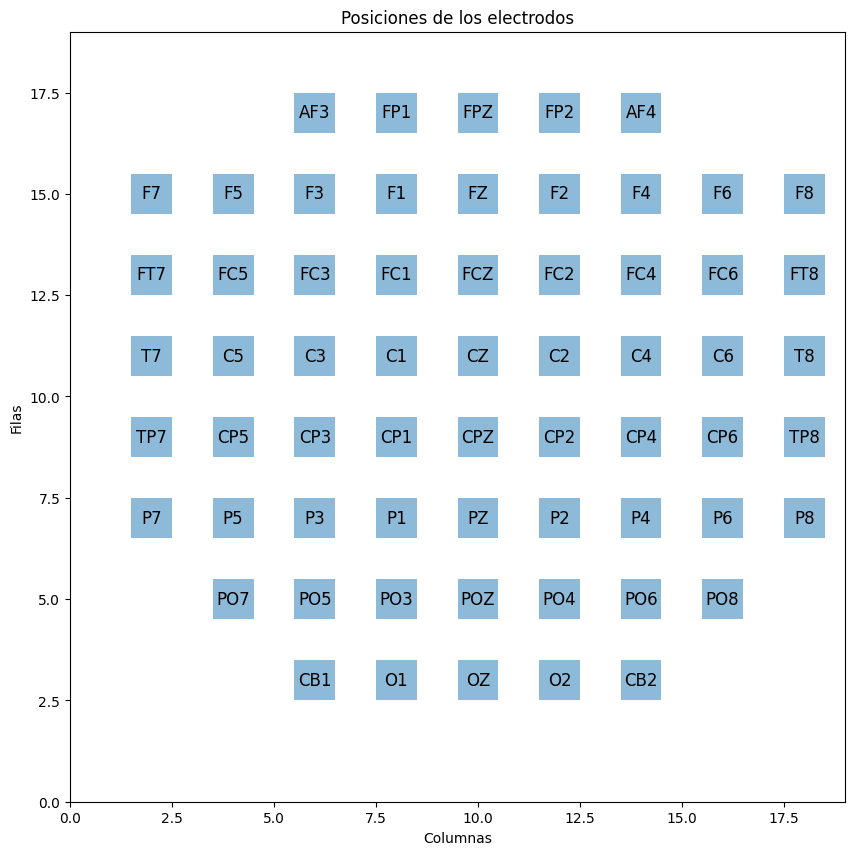

In [7]:
import matplotlib.pyplot as plt
h, w = 19, 19
sparse_map = np.zeros((h, w))
# Creamos una figura
fig, ax = plt.subplots(figsize=(10, 10))

# Recorremos el diccionario de posiciones y añadimos un cuadrado y el nombre de cada electrodo en su posición reflejada
for electrode, position in electrode_positions.items():
    x,y = position
    ax.add_patch(plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=True, alpha=0.5))
    ax.text(x, y, electrode, ha='center', va='center', fontsize=12)

# Configuramos el título, etiquetas de los ejes
ax.set_title('Posiciones de los electrodos')
ax.set_xlabel('Columnas')
ax.set_ylabel('Filas')
ax.set_xlim([0, 19])
ax.set_ylim([0, 19])

# Mostramos la figura
plt.show()

### Segments Positives

In [ ]:
start_time = time.time()  # Record the start time
# Ruta
emotion = 'POSITIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Definir los nombres de las bandas de frecuencia
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}

psd_pos_data = {}

psd_pos_2d={}
de_pos_2d={}

segment_psd_pos={}
segment_de_pos={}

segment_pos=[]
segment_pos_list=[]

input_data_pos = []

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_sec = 4
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
       
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la PSD usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_pos_data[band_name] = psd
   
            for key, value in psd_pos_data.items():
                segment_psd_pos[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_pos:
                    segment_de_pos[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_pos[band_name].append(de)  # agrega el valor de 'de' al final del array existente
        # Matriz 2D PSD           
        for band_name, values in segment_psd_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_pos_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_pos_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_pos.append([de_pos_2d,psd_pos_2d])
        segment_pos_list.append(segment_pos)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Procesing new file...:   0%|          | 2/612 [00:12<1:00:35,  5.96s/it]

#### Create Input 4D - (nºsegments,height,width,channels)

In [ ]:
start_time = time.time()  # Record the start time
# Assuming a fixed height and width (19x19 in this case)
height, width = 19, 19

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_pos_list)

# Define the number of channels based on the number of EEG channels
channels = len(freq_bands) * 2 

# Initialize the 4D input with zeros
input_4d_pos = np.zeros((num_segment, height, width, channels))

for i, segment in tqdm(enumerate(segment_pos_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                input_4d_pos[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data[band_name][y, x]

print(f"4D input shape: {input_4d_pos.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")


### Segments Neutral

In [ ]:
start_time = time.time()  # Record the start time
# Ruta
emotion = 'NEUTRAL'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Definir los nombres de las bandas de frecuencia
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}

psd_neu_data = {}

psd_neu_2d={}
de_neu_2d={}

segment_psd_neu={}
segment_de_neu={}

segment_neu=[]
segment_neu_list=[]

input_data_neu=[]

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_sec = 4
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
      
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la PSD usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neu_data[band_name] = psd
   
            for key, value in psd_neu_data.items():
                segment_psd_neu[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neu:
                    segment_de_neu[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_neu[band_name].append(de)  # agrega el valor de 'de' al final del array existente
        # Matriz 2D PSD           
        for band_name, values in segment_psd_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neu_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neu_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_neu.append([de_neu_2d,psd_neu_2d])
        segment_neu_list.append(segment_neu)

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

#### Create Input 4D - (nºsegments,height,width,channels)

In [ ]:
start_time = time.time()  # Record the start time
# Assuming a fixed height and width (19x19 in this case)
height, width = 19, 19

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neu_list)

# Define the number of channels based on the number of EEG channels
channels = len(freq_bands) * 2 

# Initialize the 4D input with zeros
input_4d_neu = np.zeros((num_segment, height, width, channels))

for i, segment in tqdm(enumerate(segment_neu_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                input_4d_neu[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data[band_name][y, x]

print(f"4D input shape: {input_4d_neu.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

### Segments Negatives

In [ ]:
start_time = time.time()  # Rec ord the start time
# Ruta
emotion ='NEGATIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)
# Definir los nombres de las bandas de frecuencia
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}

psd_neg_data = {}

psd_neg_2d={}
de_neg_2d={}

segment_psd_neg={}
segment_de_neg={}

psd_list=[]
de_list=[]

segment_neg=[]
segment_neg_list=[]

input_data_neg=[]

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_sec = 4
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
         
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la Power Spectral Density usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neg_data[band_name] = psd
   
            for key, value in psd_neg_data.items():
                segment_psd_neg[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neg:
                    segment_de_neg[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_neg[band_name].append(de)  # agrega el valor de 'de' al final del array existente
                    
        # Matriz 2D PSD           
        for band_name, values in segment_psd_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neg_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neg_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_neg.append([de_neg_2d,psd_neg_2d
        segment_neg_list.append(segment_neg)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

#### Create Input 4D - (nºsegments,height,width,channels)

In [ ]:
start_time = time.time()  # Record the start time
# Assuming a fixed height and width (19x19 in this case)
height, width = 19, 19

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neg_list)

# Define the number of channels based on the number of EEG channels
channels = len(freq_bands) * 2 

# Initialize the 4D input with zeros
input_4d_neg = np.zeros((num_segment, height, width, channels))

for i, segment in tqdm(enumerate(segment_neg_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                input_4d_neg[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data[band_name][y, x]

print(f"4D input shape: {input_4d_neg.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

### Plot Map PSD & DE (last file)

In [ ]:
sparse_map2 = np.zeros((h, w))
for band_name, values in psd_neg_2d.items():
    for i, channel_name in enumerate(channel_names):
        x, y = electrode_positions_matrix[channel_name]
        sparse_map2[x, y] = values[i]    
    
    # Crear una figura y un eje
    fig, ax = plt.subplots()

    # Crear el mapa de calor a partir de sparse_map2
    heatmap = ax.imshow(sparse_map2, cmap='inferno')

    # Establecer las etiquetas de los ejes
    ax.set_xticks(range(sparse_map2.shape[1]))
    ax.set_yticks(range(sparse_map2.shape[0]))
    ax.set_xticklabels(range(1, sparse_map2.shape[1]+1))
    ax.set_yticklabels(range(1, sparse_map2.shape[0]+1))
    ax.tick_params(axis='both', labelsize=8)

    # Añadir una barra de color
    cbar = ax.figure.colorbar(heatmap, ax=ax, cmap='inferno')
    cbar.ax.set_ylabel('Valor', rotation=-90, va="bottom", fontsize=10)

    # Añadir un título
    ax.set_title(f'{band_name}', fontsize=12)
    for channel_name, (x, y) in electrode_positions_matrix.items():
        plt.text(y, x, channel_name, color='white', fontsize=8, ha='center', va='center')
    # Mostrar el gráfico
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_sample(sample_data, electrode_positions, cmap='viridis'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    num_channels = sample_data.shape[-1]
    
    for channel_idx in range(num_channels):
        x, y, z = [], [], []
        
        for i in range(sample_data.shape[0]):
            for j in range(sample_data.shape[1]):
                x.append(i)
                y.append(j)
                z.append(sample_data[i, j, channel_idx])
        
        sc = ax.scatter(x, y, z, c=z, cmap=cmap, alpha=1.0, s=80, marker='s', edgecolors='k', linewidths=0.5)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Customize the view angle for better visualization
    ax.view_init(elev=20, azim=30)
    
    plt.colorbar(sc)
    plt.show()

# Selecciona una muestra específica (por ejemplo, la primera muestra)
sample_idx = 0
sample_data = input_4d_neg[sample_idx]

# Visualiza la muestra en 3D
plot_3d_sample(sample_data, electrode_positions)


# GAN POSITIVE

In [ ]:
start_time = time.time()
# 2. Crear el modelo GAN
# Generador
def build_generator(latent_dim):
    input = Input(shape=(latent_dim,))
    x = Dense(512 * 5 * 5)(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((5, 5, 512))(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(62, (3, 3), padding='same')(x)
    output = Activation('tanh')(x)

    model = Model(input, output)
    return model

# Discriminador
def build_discriminator(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input, x)
    return model

# GAN
def build_dcgan(generator, discriminator):
    input = Input(shape=(latent_dim,))
    output = generator(input)
    discriminator.trainable = False
    output = discriminator(output)
    model = Model(input, output)
    return model

# Dimensiones de entrada y salida
latent_dim = 100
segment_shape = X.shape[1:]

# Construye el discriminador
discriminator = build_discriminator(segment_shape)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Construye el generador
generator = build_generator(latent_dim)

# Crear el modelo DCGAN combinando el generador y el discriminador
def build_dcgan(generator, discriminator):
    input = Input(shape=(latent_dim,))
    output = generator(input)
    discriminator.trainable = False
    output = discriminator(output)
    model = Model(input, output)
    return model

dcgan = build_dcgan(generator, discriminator)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Función para entrenar la DCGAN
def train_dcgan(dcgan, generator, discriminator, dataset, epochs, batch_size):
    # Normalizar los datos del dataset entre -1 y 1
    X_train = (dataset - 127.5) / 127.5

    # Crear etiquetas para los datos reales y generados
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Entrenar el discriminador
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = dcgan.train_on_batch(noise, real_labels)

        print(f'Epoch: {epoch}, [Discriminator Loss: {d_loss[0]}, Accuracy: {100 * d_loss[1]}], [Generator Loss: {g_loss}]')

# Unir tus datos en un solo dataset
# Asegúrate de que tus datos estén normalizados y tengan la misma forma antes de unirlos
dataset = np.concatenate([input_negative, input_neutral, input_positive], axis=0)

# Entrenar la DCGAN
train_dcgan(dcgan, generator, discriminator, dataset, epochs=100, batch_size=32)

epochs = 10
batch_size = 32
sample_interval = 500

train_GAN(X, generator, discriminator, gan, epochs, batch_size, sample_interval)

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

**D_loss (Discriminator loss):** Es la pérdida del discriminador, que mide qué tan bien el discriminador puede distinguir entre datos reales y datos generados. Un valor bajo de D_loss indica que el discriminador tiene un buen rendimiento en la clasificación de los datos de entrada como reales o falsos. En el ejemplo proporcionado, D_loss es 0.0039080461574485525, lo que sugiere que el discriminador está haciendo un buen trabajo en este punto del entrenamiento.

**acc. (Discriminator accuracy):** Es la precisión del discriminador, que mide el porcentaje de datos de entrada que el discriminador clasifica correctamente como reales o falsos. En el ejemplo proporcionado, la precisión del discriminador es del 100%, lo que significa que el discriminador ha clasificado correctamente todos los datos de entrada en esta época.

**G_loss (Generator loss):** Es la pérdida del generador, que mide qué tan bien el generador puede engañar al discriminador generando datos falsos que se parezcan a los datos reales. Un valor alto de G_loss indica que el generador necesita mejorar su capacidad para generar datos que parezcan reales. En el ejemplo proporcionado, G_loss es 5.9058027267456055, lo que sugiere que el generador aún puede mejorar en la generación de datos que parezcan reales.

### Save Generator 

In [ ]:
import os

# Crear un directorio para guardar los modelos
model_dir = "MODEL_GAN"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar el modelo generador
# generator.save(os.path.join(model_dir, "generator.h5"))

# Guardar los pesos del generador
# generator.save_weights(os.path.join(model_dir, "generator_weights.h5"))

### Generate a signal

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    # Generar puntos en el espacio latente como entrada para el generador
    x_input = np.random.randn(latent_dim * n_samples)
    # Redimensionar en una matriz de entrada para el generador
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_4D_samples(generator, latent_dim, n_samples):
    # Generar puntos en el espacio latente
    x_input = generate_latent_points(latent_dim, n_samples)
    # Predecir la salida del generador a partir del ruido aleatorio
    generated_samples = generator.predict(x_input)
    return generated_samples

n_samples = 10  # El número de ejemplos que deseas generar
generated_samples = generate_4D_samples(generator, latent_dim, n_samples)

# Normalizar los ejemplos generados al rango original de tus datos (si es necesario)
# Por ejemplo, si tus datos originales están en el rango [0, 1]:
normalized_samples = (generated_samples + 1) / 2.0


In [ ]:
start_time = time.time()



elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

# Reconocimiento de emociones

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Multiply, Conv2DTranspose

In [ ]:
# Concatenate the 4D inputs for each emotion
X = np.concatenate([input_4d_pos, input_4d_neu, input_4d_neg], axis=0)

# Create labels for each emotion
# Assuming the labels are 2 for positive, 1 for neutral, and 0 for negative
y_positive = np.full((input_4d_neg.shape[0],), 2, dtype=int)
y_neutral = np.full((input_4d_neg.shape[0],), 1, dtype=int)
y_negative = np.full((input_4d_neg.shape[0],), 0, dtype=int)


# Concatenate the labels
y = np.concatenate([y_positive,y_neutral, y_negative], axis=0) 
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state= 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)
print(f'X (train/test/val):{len(X_train)},{len(X_test)},{len(X_val)} -- y (train/test/val):{len(y_train)},{len(y_test)},{len(y_val)}')

### Model 1 

In [ ]:
def build_CNN_model1(input_shape, num_classes):
    model1 = Sequential()

    model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Flatten())

    model1.add(Dense(512, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(num_classes, activation='softmax'))

    model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model1

input_shape = X_train.shape[1:]
num_classes = 3

model1 = build_CNN_model1(input_shape, num_classes)


In [ ]:
start_time = time.time()

epochs = 500
batch_size = 32

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
history = model1.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

In [ ]:
accuracy_train = model1.history.history['accuracy'][-1]
loss0, accuracy_test = model1.evaluate(X_test, y_test_onehot)

print(f'ACC. TEST: {accuracy_test} -- ACC. TRAIN: {accuracy_train} ')

### Model 2 

In [ ]:
def spatial_attention(input_tensor):
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat)
    return Multiply()([input_tensor, attention])

def build_CNN_model2(input_shape, num_classes):   

    model2 = Sequential()

    model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model2.add(spatial_attention(model2.output))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model2.add(spatial_attention(model2.output))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model2.add(spatial_attention(model2.output))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Flatten())

    model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))

    model2.add(Dense(num_classes, activation='softmax'))

    model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model2

input_shape = X_train.shape[1:]
num_classes = 3

model2 = build_CNN_model2(input_shape, num_classes)


In [ ]:
start_time = time.time()

epochs = 500
batch_size = 32

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
history = model2.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

In [ ]:
accuracy_train = model2.history.history['accuracy'][-1]
loss0, accuracy_test = model2.evaluate(X_test, y_test_onehot)

print(f'ACC. TEST: {accuracy_test} -- ACC. TRAIN: {accuracy_train} ')

### Model 3 - LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed, Flatten

def build_LSTM_model(input_shape, num_classes):
    model = Sequential()

    model.add(LSTM(64, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Dense(256, activation='relu', kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = X_train.shape[1:]
num_classes = 3

model_lstm = build_LSTM_model(input_shape, num_classes)


In [ ]:
start_time = time.time()

epochs = 500
batch_size = 32

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
history = model_lstm.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

In [ ]:
accuracy_train = model_lstm.history.history['accuracy'][-1]
loss0, accuracy_test = model_lstm.evaluate(X_test, y_test_onehot)

print(f'ACC. TEST: {accuracy_test} -- ACC. TRAIN: {accuracy_train} ')